In [2]:
# -*- coding: utf-8 -*-
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from lxml import objectify
from pandas import DataFrame
from datetime import datetime, date, time
from dateutil.parser import parse
import pandas as pd
import numpy as np
import sklearn as sk
import time
import sys
from sklearn import metrics
import re
import nltk.stem

ru_stemmer = nltk.stem.SnowballStemmer('russian')
from numpy.lib.scimath import logn
from math import e
from sklearn import preprocessing
from IPython.display import display, HTML
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib import rc
font = {'family': 'Verdana',
        'weight': 'normal'}
rc('font', **font)


In [3]:

class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([ru_stemmer.stem(w) for w in analyzer(doc)])

#vectorizerContent = StemmedCountVectorizer(min_df=1, analyzer="word", stop_words=stop_words)

In [4]:
data_start=pd.read_pickle('data/WikiData_dat_5.pkl')
#print (data_start.head(1))
topic=[]
for row in data_start['cat'].tolist():
    if "спорт" in row:
        topic.append("sport")
    else:
        topic.append("other")
print (len(topic))
data_start['topic']=topic
data_bi=data_start[['title', 'cat', 'text2', 'noun', 'topic']][:3000]
data_test=data_start[['title', 'cat', 'text2', 'noun', 'topic']][3000:4000]
d_sport = (data_bi['topic']==u'sport')
d_other=(data_bi['topic']==u'other')
data2=pd.concat([data_bi.loc[d_sport], data_bi.loc[d_other]])
data=data2[:130]
print (len(data), len(data_test))
print ('Test \n', data_test['topic'].value_counts(), '\nALL \n',  data_start['topic'].value_counts(), '\nLearning\n', data['topic'].value_counts())



10748
130 1000
Test 
 other    969
sport     31
Name: topic, dtype: int64 
ALL 
 other    10549
sport      199
Name: topic, dtype: int64 
Learning
 sport    117
other     13
Name: topic, dtype: int64


In [5]:
dfTimeUniqCat=pd.unique(data.topic.ravel())
print (len(dfTimeUniqCat))
category = data['topic'].tolist()
category = [str(i) for i in category]
#category = list(map(str, category))
content = data['title'].tolist()
stop_words = ['и']
content  = [str(x) for x in content]
for x in category:
    if not isinstance(x, str):
        print (x)


2


In [6]:
%%time
vectorizerContent = StemmedCountVectorizer (min_df=1, stop_words=stop_words, lowercase=True, analyzer="word")
vectorizerCategory = CountVectorizer (min_df=1)

X = vectorizerContent.fit_transform(content)
Xcat = vectorizerCategory.fit_transform(category)
#Xcat = category
xx = X.toarray().transpose()
xxcat = Xcat.toarray().transpose()

selected_feature_names_Cont = np.asarray(vectorizerContent.get_feature_names())
selected_feature_names_Cat = np.asarray(vectorizerCategory.get_feature_names())


Wall time: 95.1 ms


In [7]:
%%time
i = 0
Pwt = 0
for xC in Xcat:
    Pwt += np.array(xC.toarray())*np.array(X[i].toarray().transpose())
    #print (i)
    i += 1
#print (Pwt)
#%%time
i1 = 0
Theta = np.arange(Pwt.size, dtype=float).reshape(Pwt.sum(axis=1).size, Pwt[0].size)
for el4 in Pwt.sum(axis=1):
    i2 = 0
    for el1 in Pwt[i1]:
        Theta[i1][i2]=float(el1)/Pwt[i1].sum()
        i2 += 1
    i1 += 1
#print (Theta)

Wall time: 48.5 ms


In [8]:
#количество документов в коллекции
countDoc = len(content)
print ("Количество фраз в обучении = %s" %countDoc)

print ("Количество слов в обучении = %s" % len(Pwt.sum(axis=1)))
print ("Количество категорий = %s" % len(Pwt.sum(axis=0)))
print ("Слов в коллекции = %s" % Pwt.sum())

Количество фраз в обучении = 130
Количество слов в обучении = 533
Количество категорий = 2
Слов в коллекции = 808


In [9]:
def predictWordLDA(query, p):
    predictMatrixW = []
    cN=int(len(query.split(" "))/2)
    for w in query.split(" "):
        newWord = vectorizerContent.transform([w]).toarray()
        #v1=float(xxcat[1].sum())/(xxcat[1].sum()+xxcat[0].sum())
        #v0=float(xxcat[0].sum())/(xxcat[1].sum()+xxcat[0].sum())
        value_True=1.0-p
        value_False=p
        el_data= {}
        if newWord.sum()==0:
            cN+=1
            el_data['sport'] = value_True#*logn(e, cN)
            #print (selected_feature_names_Cat[0], v0)
            el_data['other'] = value_False#*logn(e, cN)
            #print (selected_feature_names_Cat[1], v1)
            predictMatrixW.append(dict(el_data))
        else:
            j=0
            for inNew in np.nditer(newWord):
                if inNew > 0:
                    #wordInDoc = float(xx[j].sum())
                    k = 0
                    for inCat in Pwt[j]:
                        if inCat > 0:
                            #wordInCat = float(xxcat[k].sum())
                            #*(1-wordInCat/countDoc)*(1-wordInDoc/countDoc)
                            cVal=Theta[j][k]#*(1-wordInCat/countDoc)*(1-wordInDoc/countDoc)
                            el_data[selected_feature_names_Cat[k]] = cVal
                            #el_data[selected_feature_names_Cat[0]] = cVal
                            #el_data['other'] = 1.0-cVal
                            #print (selected_feature_names_Cat[k], k, j, cVal)
                            predictMatrixW.append(dict(el_data))
                        k +=1
                j+=1
    dfMW = DataFrame(predictMatrixW)
    dfSumMW=dfMW.sum()
    i =0
    dfSumMW.sort_values(ascending=False, kind='quicksort', na_position='last', inplace=True)
    for el in dfSumMW.T.iteritems():
        i += 1
        if i < 2:
            #return ("%s; %f" % (el[0], el[1]/dfSumMW.sum()))
            return (el[0], el[1]/dfSumMW.sum())
        
        

In [10]:
clean_test_reviews = []
for query in data_test['title']:
    clean_test_reviews.append(query)

In [11]:
%%time
penalty=[0.99, 0.95, 0.9, 0.85, 0.8, 0.7, 0.5, 0.4]
score_p=[]
for v in penalty:
    i = 0
    outputpredict = []
    for query in data_test['title']:
        out=predictWordLDA(query, v)
        outputpredict.append(out[0])
        i+=1
    score = metrics.accuracy_score(data_test.topic.tolist(), outputpredict)
    score_p.append(score)
    print("accuracy:   %0.3f" % score)
    confmat=confusion_matrix(data_test.topic.tolist(), outputpredict)
    print (confmat)

    

accuracy:   0.921
[[905  64]
 [ 15  16]]
accuracy:   0.915
[[899  70]
 [ 15  16]]
accuracy:   0.910
[[892  77]
 [ 13  18]]
accuracy:   0.892
[[874  95]
 [ 13  18]]
accuracy:   0.868
[[849 120]
 [ 12  19]]
accuracy:   0.777
[[754 215]
 [  8  23]]
accuracy:   0.114
[[ 83 886]
 [  0  31]]
accuracy:   0.058
[[ 27 942]
 [  0  31]]
Wall time: 28.1 s


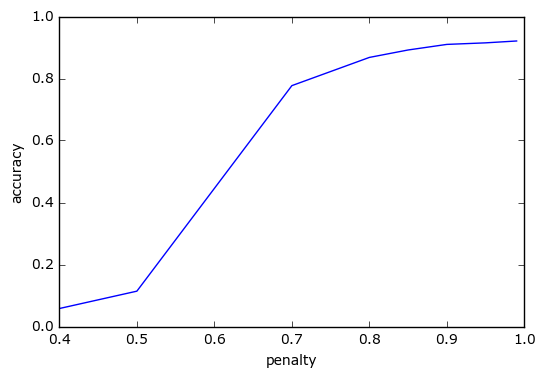

In [15]:
plt.figure()
plt.plot(penalty, score_p)
plt.ylabel('accuracy')
plt.xlabel('penalty')
plt.savefig('data/BI-TM.png')
plt.show()